# Generic ALP realignment

In [87]:
%run runner.py
%run observables.py
%run analysis_tools.py
%run plot_tools.py
%run generic_alp.py
import tqdm.notebook
import matplotlib as mpl

## Parameter space from paper

In [4]:
def plot(version, f_a):
    H_inf_index = 0
    f_a_index = 0
    data = load_data("generic_alp", version)
    eta = data["eta"][H_inf_index, :, :, f_a_index]
    m_a = data["m_a"]
    Gamma_inf = data["Gamma_inf"]
    H_inf = data["H_inf"]
    
    if f_a is None:
        f_a = data["f_a"][f_a_index]
        dilution = data["dilution"][H_inf_index, :, :, f_a_index]
    else:
        rho_end_rad = data["rho_end_rad"][H_inf_index, :, :, f_a_index]
        rho_end_axion = data["rho_end_axion"][H_inf_index, :, :, f_a_index]     
        f_a_used = data["f_a"][f_a_index]
        dilution = np.zeros(eta.shape)
        for i in tqdm.notebook.tqdm(range(len(Gamma_inf))):
            for j in range(len(m_a)):
                dilution[i, j] = compute_dilution_factor_from_axion_decay(10.0, 
                        rho_end_rad[i, j], rho_end_axion[i, j] / f_a_used**2 * f_a**2, 
                        (m_a[j],), f_a, realignment_axion_field, False)  
    
    eta_B = np.abs(dilution * eta)
    A = np.log10(eta_B / eta_B_observed)
    levels = find_level(np.log10(m_a), np.log10(Gamma_inf), A)
    
    plt.figure()
    plt.contour(m_a, Gamma_inf, A)
    for xs, ys in levels:
        plt.plot(10**xs, 10**ys, "r", lw=3)
    plt.xscale("log")
    plt.yscale("log")
    plt.colorbar(label=r"$log_{10}(\eta_B / \eta_B^\mathrm{obs})$")
    plt.xlabel("$m_a$ / GeV")
    plt.ylabel(r"$\Gamma_\mathrm{inf}$ / GeV")
    plt.title(f"f_a = {f_a:.2e}, H_inf = {H_inf[H_inf_index]:.2e}")

  0%|          | 0/30 [00:00<?, ?it/s]

/net/cip/home/janik.riess/masters-project/transport_eq_in_time/decay_process.py:13: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(rho_field + rho_rad) * C # NOTE: sometimes with is evalulated at weird arguments -> warnings


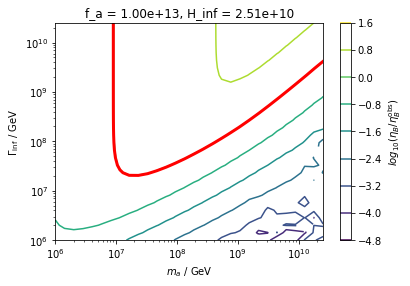

In [7]:
plot(1, 1e13)

Text(0.5, 1.0, '$\\eta_B = \\eta_B^\\mathrm{obs}$ for $H_inf = 2.51\\cdot 10^{10} \\, \\mathrm{GeV}$')

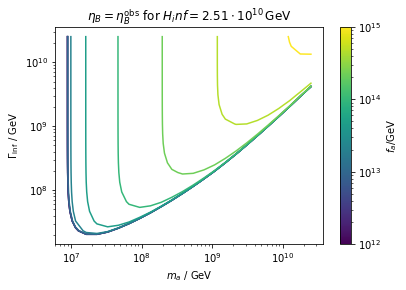

In [14]:
version = 1
correct_alp_curves_filename = os.path.join(runner.datadir, f"generic_alp_correct_curves{version}.pkl")
with open(correct_alp_curves_filename, "rb") as fhandle:
    f_a_list, correct_asym_curves = pickle.load(fhandle)
    
cmap = plt.cm.get_cmap("viridis")
norm = mpl.colors.LogNorm(vmin=np.min(f_a_list), vmax=np.max(f_a_list))
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for f_a, curve in zip(f_a_list, correct_asym_curves):
    c = mappable.to_rgba(f_a)
    for xs, ys in curve:
        plt.loglog(xs, ys, color=c)

plt.colorbar(mappable=mappable, label=r"$f_a / \mathrm{GeV}$")
plt.xlabel("$m_a$ / GeV")
plt.ylabel(r"$\Gamma_\mathrm{inf}$ / GeV")
plt.title(f"$\\eta_B = \\eta_B^\\mathrm{{obs}}$ for $H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf[H_inf_index], 2)} \\, \\mathrm{{GeV}}$")

## Example Evolution 

In [27]:
list(Status)

[<Status.OK: 1>,
 <Status.ASYM_CONVERGENCE_FAILURE: 2>,
 <Status.RELIC_DENSITY_CONVERGENCE_FAILURE: 3>,
 <Status.AXION_OSCILLATES_BEFORE_INFLATION: 4>,
 <Status.INFLATON_DECAYS_DURING_INFLATION: 5>,
 <Status.ISOCURVATURE_BOUNDS: 6>]

In [15]:
%run observables.py
f_a = 1e15
H_inf = f_a*2*np.pi*1e-5 
def example_evolution(Gamma_inf, m_a):
    return compute_observables(H_inf, Gamma_inf, (m_a,), f_a, 
                        realignment_axion_field, (1.0, 0.0),
                        calc_init_time=True, debug=True)

conv factor: 0.1
step = 1
T_max = 5.602381e+12
t_eq = 2.9026457685899234
tmax_inf_time = 2.9026457685899234, tmax_axion_time = 29.02645768589923
calculcated initial integration time:
tmax_inf_time = 2.9026457685899234 tmax_axion_time = 29.02645768589923
rh: 0.3612494468688965
axion: 0.6022212505340576
transport eq.: 0.4687681198120117
B-L start .. end: 0.0 -1.2319344927125616e-08
B-L range: -2.5610810900200877e-08 0.0
delta = 1.7271327608592897 rtol_asym = 0.001
step = 2
rh: 0.0020101070404052734
axion: 0.08825898170471191
transport eq.: 0.22208809852600098
B-L start .. end: -1.231934492712562e-08 -1.1754108088035177e-08
B-L range: -1.2337970470884281e-08 -1.1752906587091664e-08
delta = 0.048446907818957066 rtol_asym = 0.001
step = 3
rh: 0.002095937728881836
axion: 0.08105278015136719
transport eq.: 0.21858978271484375
B-L start .. end: -1.175410808803518e-08 -1.1591730123140683e-08
B-L range: -1.17824284760459e-08 -1.1588713128331005e-08
delta = 0.016563753663013457 rtol_asym = 0.001


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


initial (rad, axion): 8.662113798917072e+47 3.3466840572797793e+41
axion decay took: 0.19838237762451172 seconds


/home/anna-jana/Documents/masters-project/transport_eq_in_time/decay_process.py:13: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(rho_field + rho_rad) * C # NOTE: sometimes with is evalulated at weird arguments -> warnings


(9.905220002554224e-11,
 0.00392631497409953,
 8.662113798917072e+47,
 3.3466840572797793e+41,
 0.0,
 1.0)

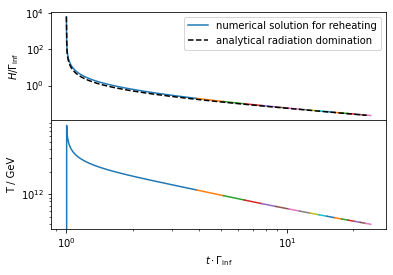

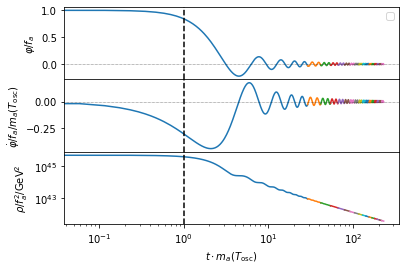

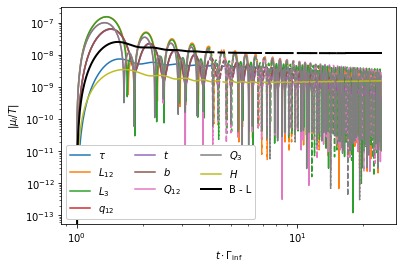

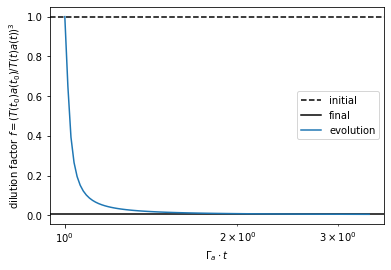

In [12]:
example_evolution(1e7, 1e8)

conv factor: 10.0
step = 1
T_max = 9.962599e+12
t_eq = 36.93447988685768
tmax_inf_time = 36.93447988685768, tmax_axion_time = 3.693447988685768
calculcated initial integration time:
tmax_inf_time = 36.93447988685768 tmax_axion_time = 3.693447988685768
rh: 0.11007285118103027
axion: 0.1679668426513672
transport eq.: 0.20083284378051758
B-L start .. end: 0.0 -5.5967526737437356e-08
B-L range: -5.5967526737437356e-08 0.0
delta = 4.9076743147765445 rtol_asym = 0.001
step = 2
rh: 0.008522510528564453
axion: 0.16575837135314941
transport eq.: 0.33674001693725586
B-L start .. end: -5.5967526737437356e-08 -7.456012648023222e-08
B-L range: -7.458797064071952e-08 -5.5967526737437356e-08
delta = 0.284342319843011 rtol_asym = 0.001
step = 3
rh: 0.00012183189392089844
axion: 0.07071566581726074
transport eq.: 0.26708483695983887
B-L start .. end: -7.456012648023222e-08 -7.45848102509307e-08
B-L range: -7.488516499354523e-08 -7.456012648023222e-08
delta = 0.004351345145735184 rtol_asym = 0.001
step 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


initial (rad, axion): 2.6589776457057805e+46 2.4825638413138115e+40


/home/anna-jana/Documents/masters-project/transport_eq_in_time/decay_process.py:13: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(rho_field + rho_rad) * C # NOTE: sometimes with is evalulated at weird arguments -> warnings


axion decay took: 0.22452688217163086 seconds


(6.39619749802244e-10,
 0.0001228697464385378,
 2.6589776457057805e+46,
 2.4825638413138115e+40,
 0.0,
 1.0)

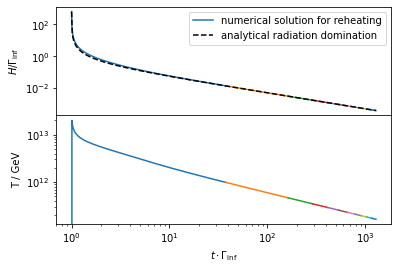

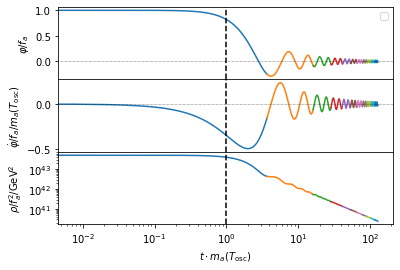

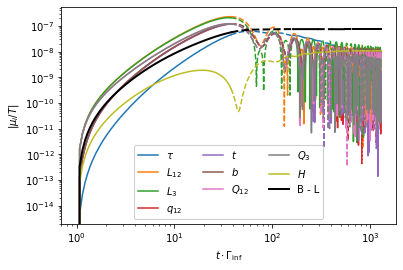

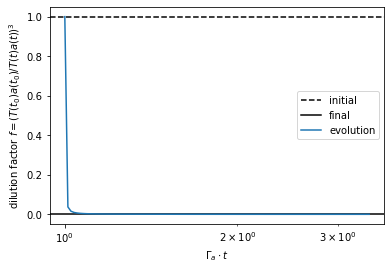

In [13]:
example_evolution(1e8, 1e7)

In [158]:
%run observables.py

Gamma_inf = 1e7
m_a = 1e8
scale = decay_process.find_scale(Gamma_inf)
axion_model = realignment_axion_field
axion_parameter = (m_a,)
energy_scale = axion_model.find_dynamical_scale(*axion_parameter)
conv_factor = Gamma_inf / energy_scale
source_vector = transport_equation.source_vector_weak_sphaleron
tmax_axion = 100.0
sol_rh, T_and_H_fn, T_and_H_and_T_dot_fn, sol_axion, axion_source, sol_transp_eq, tmax_axion = \
    solve_system(H_inf, 0.0, 3*decay_process.M_pl**2*H_inf**2, (1.0, 0.0), np.zeros(transport_equation.N),
                 tmax_axion, conv_factor, Gamma_inf, scale, 
                 axion_parameter, axion_model, source_vector,
                 False, False)
tmax_inf = tmax_axion * conv_factor
tinfs = np.geomspace(decay_process.t0, decay_process.t0 + tmax_inf, 500)
taxs = (tinfs - decay_process.t0) / conv_factor
Ts, Hs, Tdots = T_and_H_and_T_dot_fn(tinfs)
theta_dots = sol_axion.sol(taxs)[1, :]
theta = sol_axion.sol(taxs)[0, :]
red_chem_pots = sol_transp_eq(np.log(tinfs))
gammas = [transport_equation.calc_rate_vector(T) for T in Ts]
source = theta_dots / Ts / 1e-13 # m_a
rate = - np.array([gamma @ transport_equation.charge_vector @ transport_equation.charge_vector_B_minus_L 
                                for gamma in gammas]) / Hs

/tmp/ipykernel_11345/1074697848.py:25: RuntimeWarning: invalid value encountered in true_divide
  source = theta_dots / Ts / 1e-13 # m_a


(1.0, 11.0)

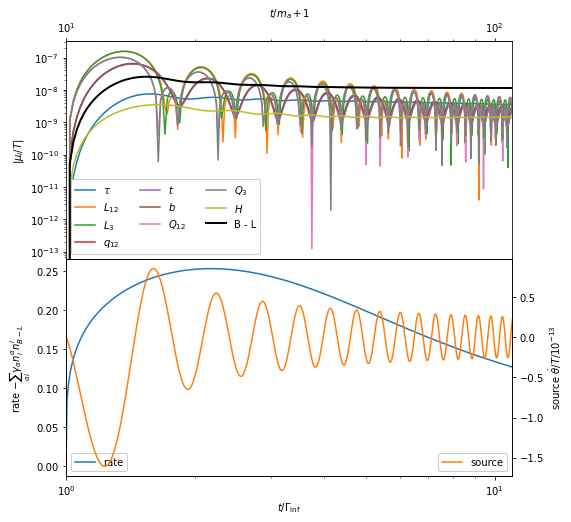

In [160]:
fig = plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
fig.subplots_adjust(hspace=0)

plot_charge_evolution(conv_factor, [sol_axion], [sol_transp_eq], show_steps=False, fig=fig)
#plt.gca().xaxis.tick_top()
#plt.gca().xaxis.set_label_position("top") 
plt.xlim(tinfs[0], tinfs[-1])
plt.xticks([],[])
secax = plt.gca().secondary_xaxis("top", 
    functions=(lambda inf: inf / conv_factor, lambda ax: ax * conv_factor))
secax.set_xlabel(r"$t / m_a + 1$")

plt.subplot(2,1,2)

ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.semilogx(tinfs, rate, color="tab:blue", label="rate")
ax2.semilogx(tinfs, source, color="tab:orange", label="source")
ax1.set_xlabel(r"$t / \Gamma_\mathrm{inf}$")
ax1.set_ylabel(r"rate $- \sum_{\alpha i} \gamma_\alpha n^\alpha_i n_{B - L}^i$")
ax2.set_ylabel(r"source $\dot{\theta} / T / 10^{-13}$")
ax1.legend(loc=3, framealpha=1)
ax2.legend(loc=4, framealpha=1)
plt.xlim(tinfs[0], tinfs[-1])

#plt.suptitle("test")
#plt.tight_layout()
#plt.savefig("plot.pdf")